Using estimator: histgb


[*********************100%***********************]  1 of 1 completed


Samples: total=2381 | train=1905 | test=476

--- Baseline (predict 0% return) ---

=== Baseline (Price metrics) ===
MAE (₹): 13.5024
R²     : 0.9649

--- HISTGB Model ---

=== Test (Price metrics) ===
MAE (₹): 15.4809
R²     : 0.9550

📄 Saved test predictions: test_predictions_gbm.csv

================ NEXT TRADING DAY FORECAST ================
Ticker          : RELIANCE.NS
Last trading    : 2025-11-03  (Close_t = 1,484.70)
Pred log-ret    : +0.00169  (~+0.17%)
Pred Close (t+1): 1,487.21


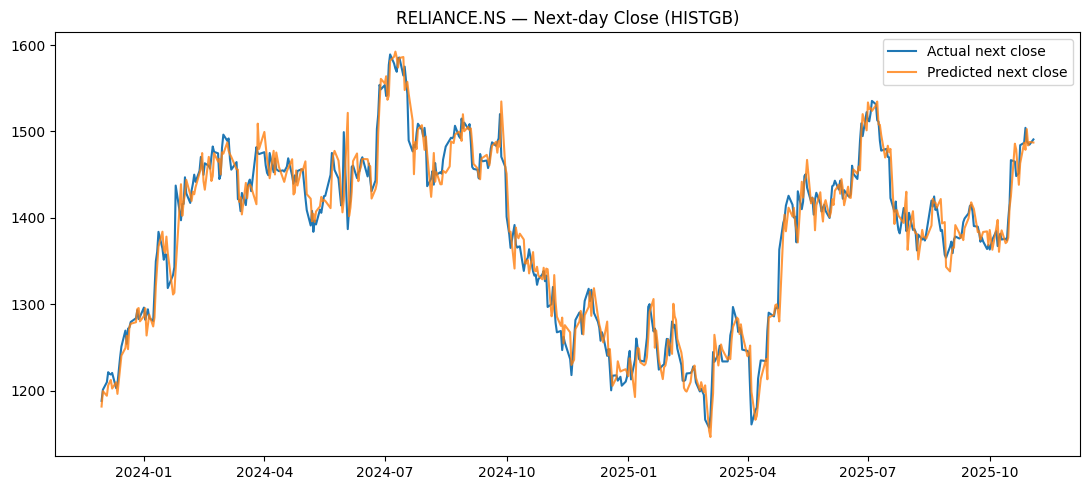


✅ Saved model: gbm_nextday_return.model


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Next-day Close Prediction via Gradient Boosting (Auto: XGBoost -> LightGBM -> HistGB)
-------------------------------------------------------------------------------------

- Adjusted OHLCV (no split/div noise)
- Predict next-day *log return*; reconstruct next-day price
- Tries XGBoost first; if unavailable, falls back to LightGBM; else scikit-learn HistGB
- Time-ordered split, price-space metrics, CSV export, next-day forecast
"""

# ========================== Config ==========================
TICKER      = "RELIANCE.NS"
START_DATE  = "2016-01-01"
END_DATE    = None
TEST_SIZE   = 0.20
EXPORT_CSV  = True
CSV_PATH    = "test_predictions_gbm.csv"
PLOT        = True
CLIP_SIGMAS = 4.0   # clip predicted returns to +/- k * sigma_train
SAVE_MODEL  = True
MODEL_PATH  = "gbm_nextday_return.model"

# ========================= Imports ==========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Try import order: XGBoost -> LightGBM -> HistGradientBoosting
EST_NAME, ESTIMATOR = None, None
try:
    import xgboost as xgb
    EST_NAME = "xgboost"
except Exception as e_xgb:
    try:
        from lightgbm import LGBMRegressor
        EST_NAME = "lightgbm"
    except Exception as e_lgbm:
        from sklearn.ensemble import HistGradientBoostingRegressor
        EST_NAME = "histgb"

# ===================== Feature Engineering ==================
def rsi_wilder(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)

FEATURES = [
    "ret1","ret3","ret5","ret10","ret20",
    "vol5","vol10","vol20",
    "rsi14","vol_z20",
    "hl_range_pct","oc_range_pct",
    "ma5_dev","ma10_dev","ma20_dev","ma50_dev"
]

def make_features(df):
    df = df.copy()
    df["ret1"]  = df["Close"].pct_change(1)
    df["ret3"]  = df["Close"].pct_change(3)
    df["ret5"]  = df["Close"].pct_change(5)
    df["ret10"] = df["Close"].pct_change(10)
    df["ret20"] = df["Close"].pct_change(20)

    df["vol5"]  = df["ret1"].rolling(5).std()
    df["vol10"] = df["ret1"].rolling(10).std()
    df["vol20"] = df["ret1"].rolling(20).std()

    df["rsi14"] = rsi_wilder(df["Close"], 14)
    df["hl_range_pct"] = (df["High"] - df["Low"]) / df["Close"]
    df["oc_range_pct"] = (df["Close"] - df["Open"]) / df["Close"]

    vol_ma = df["Volume"].rolling(20).mean()
    vol_sd = df["Volume"].rolling(20).std()
    df["vol_z20"] = (df["Volume"] - vol_ma) / vol_sd

    for w in (5,10,20,50):
        ma = df["Close"].rolling(w).mean()
        df[f"ma{w}_dev"] = (df["Close"] / ma) - 1.0

    df["y_logret_next"] = np.log(df["Close"].shift(-1) / df["Close"])
    return df.dropna().copy()

def time_split(df, test_size):
    n = len(df)
    n_test = int(np.floor(n * test_size))
    return df.iloc[:n-n_test].copy(), df.iloc[n-n_test:].copy()

# ======================= Eval Helpers =======================
def eval_price_metrics(close_t, y_true, y_pred, label="Test"):
    actual_next = close_t * np.exp(y_true)
    pred_next   = close_t * np.exp(y_pred)
    mae_price = mean_absolute_error(actual_next, pred_next)
    r2_price  = r2_score(actual_next, pred_next)
    print(f"\n=== {label} (Price metrics) ===")
    print(f"MAE (₹): {mae_price:,.4f}")
    print(f"R²     : {r2_price:,.4f}")
    return actual_next, pred_next, {"MAE_price": mae_price, "R2_price": r2_price}

# =================== Estimator Factory ======================
def make_estimator():
    global EST_NAME
    if EST_NAME == "xgboost":
        params = dict(
            n_estimators=600,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            reg_alpha=0.0,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=0  # let xgb decide; set to >0 if you want
        )
        model = xgb.XGBRegressor(**params)
        return EST_NAME, model

    elif EST_NAME == "lightgbm":
        model = LGBMRegressor(
            n_estimators=1200,
            learning_rate=0.02,
            max_depth=-1,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=0.0,
            reg_alpha=0.0,
            random_state=42,
        )
        return EST_NAME, model

    else:  # HistGradientBoostingRegressor (pure sklearn, no external deps)
        from sklearn.ensemble import HistGradientBoostingRegressor
        model = HistGradientBoostingRegressor(
            loss="squared_error",
            learning_rate=0.05,
            max_depth=None,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=0.0,
            max_iter=1000,
            random_state=42
        )
        return "histgb", model

# ========================== Main ============================
def main():
    print(f"Using estimator: {EST_NAME}")
    print(f"Downloading {TICKER} (adjusted OHLCV)...")
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True, multi_level_index=False)
    df = df[["Open","High","Low","Close","Volume"]].copy()

    data = make_features(df)
    X = data[FEATURES]
    y = data["y_logret_next"]
    close_t = df.loc[X.index, "Close"]

    X_train, X_test = time_split(X, TEST_SIZE)
    y_train, y_test = time_split(y.to_frame(), TEST_SIZE)
    y_train, y_test = y_train.squeeze(), y_test.squeeze()
    close_t_train, close_t_test = time_split(close_t.to_frame(), TEST_SIZE)
    close_t_train, close_t_test = close_t_train.squeeze(), close_t_test.squeeze()

    print(f"Samples: total={len(X)} | train={len(X_train)} | test={len(X_test)}")

    name, model = make_estimator()

    # Fit (basic; you can add TimeSeriesSplit CV if you like)
    if name == "xgboost":
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    elif name == "lightgbm":
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:  # histgb
        model.fit(X_train, y_train)

    # Predict & clip outliers in return space
    sigma_tr = y_train.std()
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, -CLIP_SIGMAS*sigma_tr, CLIP_SIGMAS*sigma_tr)

    # Baseline (0% return)
    baseline = np.zeros_like(y_test.values)
    print("\n--- Baseline (predict 0% return) ---")
    _ = eval_price_metrics(close_t_test.values, y_test.values, baseline, label="Baseline")

    # Model eval
    print(f"\n--- {name.upper()} Model ---")
    actual_next, pred_next, _ = eval_price_metrics(close_t_test.values, y_test.values, y_pred, label="Test")

    # Feature importance (if supported)
    try:
        importances = None
        if name == "xgboost":
            importances = model.feature_importances_
        elif name == "lightgbm":
            importances = model.feature_importances_
        if importances is not None:
            imp = pd.Series(importances, index=FEATURES).sort_values(ascending=False)
            print("\nTop Features (importance):")
            print(imp.head(10).to_string(float_format=lambda x: f"{x:,.4f}"))
    except Exception:
        pass

    # Export
    if EXPORT_CSV:
        out = pd.DataFrame({
            "date": X_test.index,
            "close_t": close_t_test.values,
            "actual_next_close": actual_next,
            "pred_next_close": pred_next,
            "pred_logret": y_pred,
            "actual_logret": y_test.values,
        }).set_index("date")
        out["residual"] = out["actual_next_close"] - out["pred_next_close"]
        out.to_csv(CSV_PATH, float_format="%.6f")
        print(f"\n📄 Saved test predictions: {CSV_PATH}")

    # Next-day forecast
    last_feats = X.iloc[[-1]]
    last_date = X.index[-1]
    last_close = df.loc[last_date, "Close"]
    rhat_next = np.clip(model.predict(last_feats)[0], -CLIP_SIGMAS*sigma_tr, CLIP_SIGMAS*sigma_tr)
    pred_next_price = last_close * np.exp(rhat_next)

    print("\n================ NEXT TRADING DAY FORECAST ================")
    print(f"Ticker          : {TICKER}")
    print(f"Last trading    : {pd.Timestamp(last_date).date()}  (Close_t = {last_close:,.2f})")
    print(f"Pred log-ret    : {rhat_next:+.5f}  (~{(np.exp(rhat_next)-1)*100:+.2f}%)")
    print(f"Pred Close (t+1): {pred_next_price:,.2f}")
    print("===========================================================")

    # Plot
    if PLOT:
        plt.figure(figsize=(11,5))
        plt.plot(X_test.index, actual_next, label="Actual next close")
        plt.plot(X_test.index, pred_next, label="Predicted next close", alpha=0.8)
        plt.title(f"{TICKER} — Next-day Close ({name.upper()})")
        plt.legend(); plt.tight_layout(); plt.show()

    # Save model
    if SAVE_MODEL:
        if name == "xgboost":
            model.save_model(MODEL_PATH)
        else:
            joblib.dump(model, MODEL_PATH)
        print(f"\n✅ Saved model: {MODEL_PATH}")

if __name__ == "__main__":
    main()
